<a href="https://drive.google.com/file/d/1b7tSyJBpWggHEBGdWa80JdKh7VNq2FEf/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

In [260]:
from scipy import stats

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [258]:
import numpy as np
from scipy.stats import chisquare

def serial_test(sample, K=10):
    points = np.array(sample).reshape(-1, 2)
    bins = np.linspace(0, 1, K + 1)
    observed, _ = np.histogramdd(points, bins=[bins] * 2)
    expected = len(points) / (K**2)
    
    chi2_stat, p_value = chisquare(observed.flatten(), f_exp=expected)
    
    return chi2_stat, p_value

samples = [rng() for j in range(2*10)]
chi2_stat, p_value = serial_test(sample)
print("Chi-square statistics = {:.3f}, p value = {:.3f}".format(chi2_stat, p_value))

Chi-square statistics = 90.000, p value = 0.730


Значение p value достаточно велико (> 0.05), поэтому гипотеза о том, что данные были распределены равномерно на [0,1]x[0,1], не опровергается.

### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [ ]:
# Your code here

In [284]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [129]:
from scipy.spatial.distance import pdist, squareform

def generate_points(rng_func, n=8000, side=10000):
    return np.array([[rng_func() * side, rng_func() * side] for _ in range(n)])

def find_min_distance(points):
    distances = pdist(points)
    return np.min(distances)

def exponential_transform(d_squared, mean=0.995):
    return 1 - np.exp(-d_squared / mean)

def run_test(rng_func, num_tests=100, n=8000, side=10000):
    results = []
    for _ in range(num_tests):
        points = generate_points(rng_func, n, side)
        min_distance = find_min_distance(points)
        d_squared = min_distance ** 2
        transformed = exponential_transform(d_squared)
        results.append(transformed)
    return results

results_bad = run_test(rng_bad)
results_good = run_test(rng)

ks_stat_bad, p_value_bad = stats.kstest(results_bad, 'uniform')
print("rng_bad: KS Statistic = {}, p value = {}".format(ks_stat_bad, p_value_bad))

ks_stat_good, p_value_good = stats.kstest(results_good, 'uniform')
print("rng_good: KS Statistic = {}, p value = {}".format(ks_stat_good, p_value_good))

rng_bad: KS Statistic = 0.29136130397304083, p value = 5.1565547823988216e-08
rng_good: KS Statistic = 0.10540716863566468, p value = 0.2017070315550451


Используя тест минимального расстояния по ссылке ниже, получили следующие результаты: p value статистики Колмогорова Смирнова для rng_bad меньше 0.05, поэтому гипотеза о том, что сгенерированные числа распределены равномерно опрогвергается. p value статистики Колмогорова Смирнова для rng_good больше 0.05 и, следовательно, не опровергается, то есть числа, сгенерированные rng_good, имеют равномерное распределение.

* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

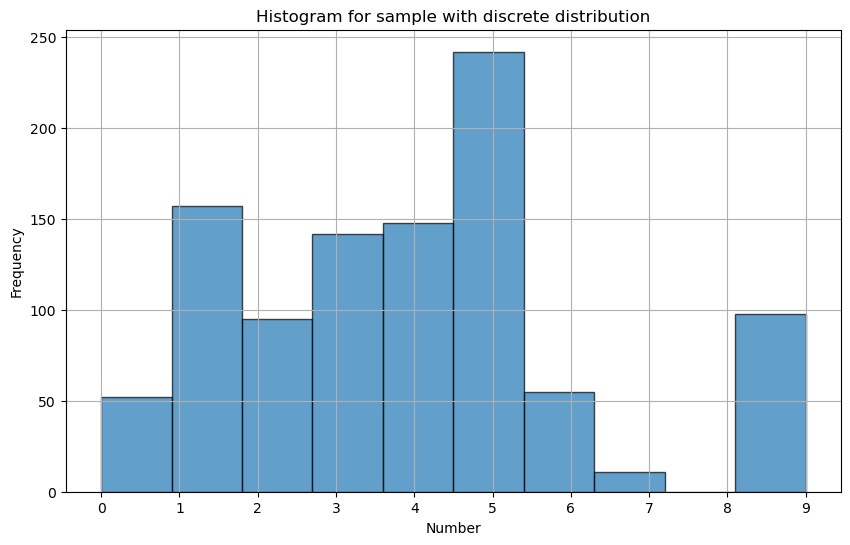

In [280]:
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
digits = np.arange(10)

probabilities = weights / weights.sum()

sorted_indices = np.argsort(probabilities)
sorted_probs = probabilities[sorted_indices]
sorted_digits = digits[sorted_indices]

n = 1000
sample = np.random.choice(sorted_digits, 1000, p=sorted_probs)

plt.figure(figsize=(10, 6))
plt.hist(sample, edgecolor='black', alpha=0.7)
plt.xticks(digits)
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Histogram for sample with discrete distribution')
plt.grid(True)
plt.show()

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

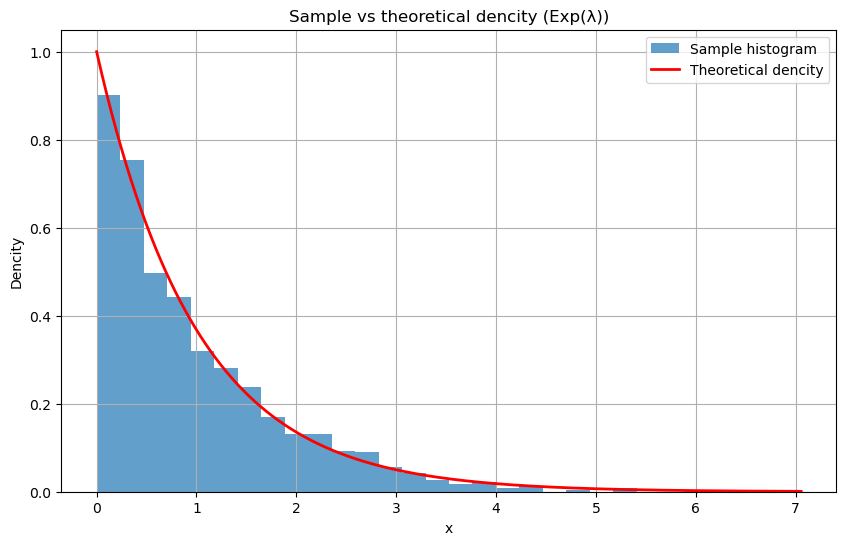

In [41]:
lambda_ = 1.0 
n = 1000 
u = np.random.rand(n)
sample = -np.log(u) / lambda_

plt.figure(figsize=(10, 6))
plt.hist(sample, bins=30, density=True, alpha=0.7, label='Sample histogram')

x = np.linspace(0, np.max(sample), 1000)
plt.plot(x, lambda_ * np.exp(-lambda_ * x), 'r-', linewidth=2, label='Theoretical dencity')

plt.xlabel('x')
plt.ylabel('Dencity')
plt.title('Sample vs theoretical dencity (Exp(λ))')
plt.legend()
plt.grid(True)
plt.show()

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

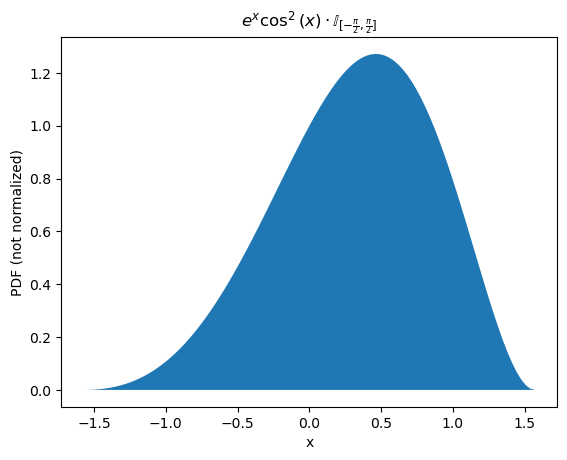

In [43]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

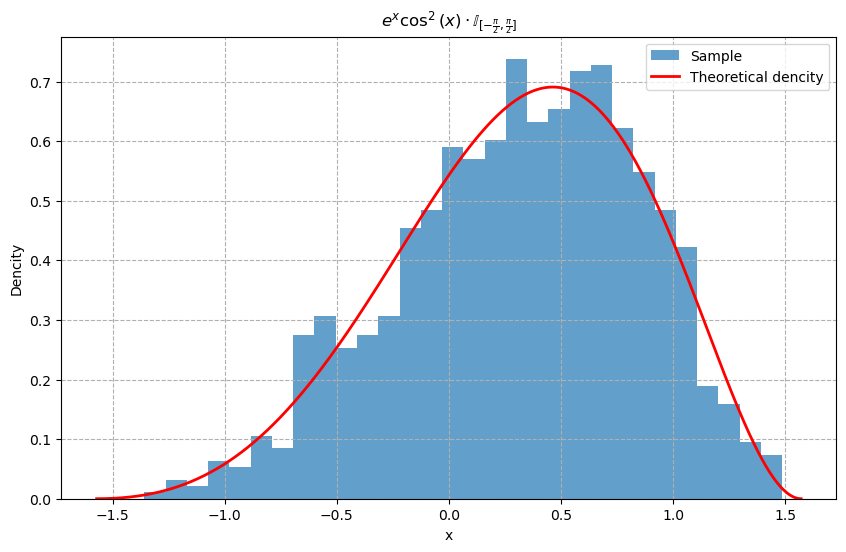

In [282]:
from scipy.integrate import quad

def integrand(x):
    return np.exp(x) * (np.cos(x))**2

Z, _ = quad(integrand, -np.pi/2, np.pi/2)

C = np.pi * np.max(np.exp(x) * (np.cos(x))**2)
n = 1000

sample = []
while len(sample) < n:
    x = np.random.uniform(-np.pi/2, np.pi/2)
    u = np.random.uniform(0, C * (1/np.pi))
    if u <= np.exp(x) * (np.cos(x))**2:
        sample.append(x)

plt.figure(figsize=(10, 6))
plt.hist(sample, bins=30, density=True, alpha=0.7, label='Sample')

x_vals = np.linspace(-np.pi/2, np.pi/2, 1000)
pdf = np.exp(x_vals) * (np.cos(x_vals))**2 / Z
plt.plot(x_vals, pdf, 'r-', linewidth=2, label='Theoretical dencity')

plt.xlabel('x')
plt.ylabel('Dencity')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

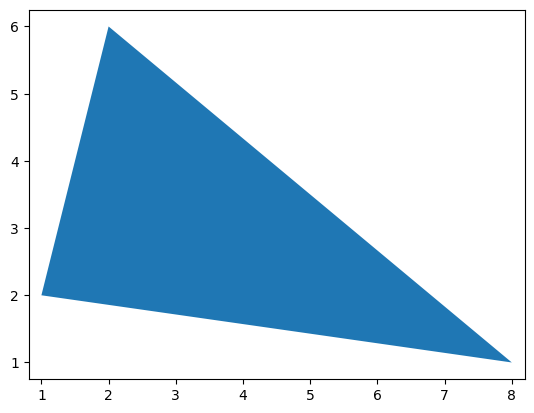

In [132]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

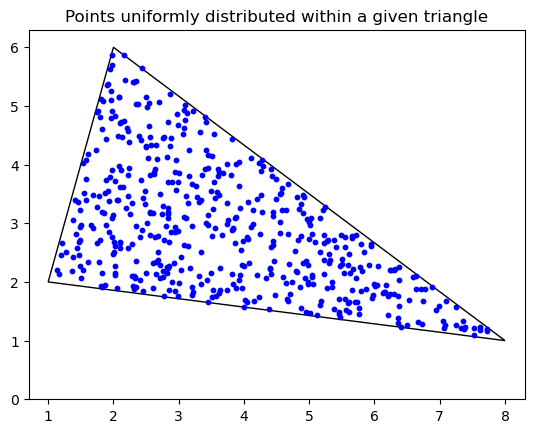

In [190]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

triangle_vertices = np.array([[1, 2], [2, 6], [8, 1]])

u = np.random.uniform(0, 1, 500)
v = np.random.uniform(0, 1, 500)

mask = u + v > 1
u[mask] = 1 - u[mask]
v[mask] = 1 - v[mask]

x = triangle_vertices[0, 0] + (triangle_vertices[1, 0] - triangle_vertices[0, 0]) * u + (triangle_vertices[2, 0] - triangle_vertices[0, 0]) * v
y = triangle_vertices[0, 1] + (triangle_vertices[1, 1] - triangle_vertices[0, 1]) * u + (triangle_vertices[2, 1] - triangle_vertices[0, 1]) * v

fig, ax = plt.subplots()

polygon = Polygon(triangle_vertices, closed=True, edgecolor='black', facecolor='none')
ax.add_patch(polygon)

ax.scatter(x, y, s=10, color='blue')

plt.xlim(0.7, 8.3)
plt.ylim(0, 6.3)
plt.title("Points uniformly distributed within a given triangle")
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

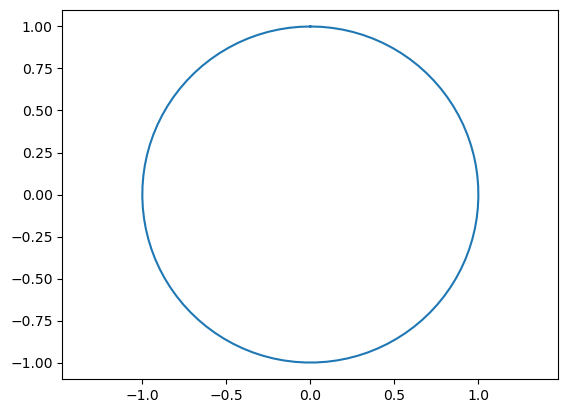

In [176]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

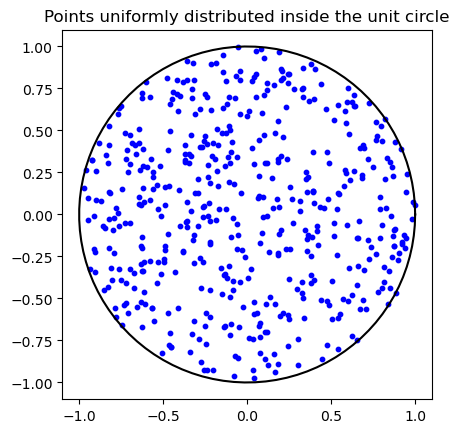

In [199]:
theta = 2 * np.pi * np.random.uniform(0, 1, 500)
r = np.sqrt(np.random.rand(500))

x = r * np.cos(theta)
y = r * np.sin(theta)

fig, ax = plt.subplots()
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(t), np.sin(t), color='black')

ax.scatter(x, y, s=10, color='blue')

ax.set_aspect('equal')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title("Points uniformly distributed inside the unit circle")
plt.show()

# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [201]:
import seaborn as sns

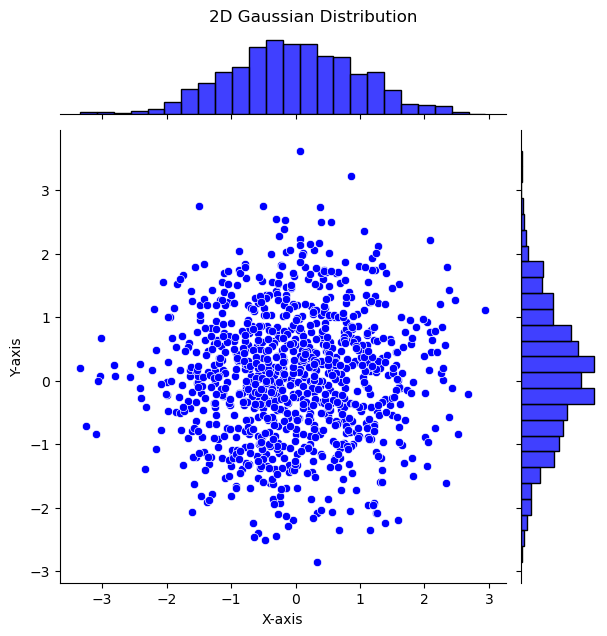

In [203]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

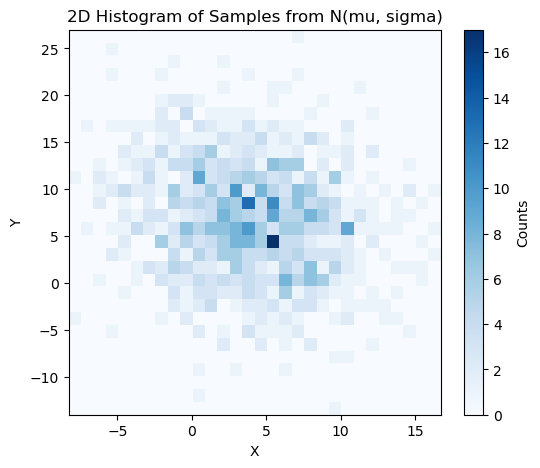

Exact mean = [4. 7.]
Sample mean = [3.90558868 6.75283601]
Exact covariance matrix = [[20. -4.]
 [-4. 40.]]
Exact covariance matrix = [[19.29209383 -4.31472944]
 [-4.31472944 34.43541156]]


In [238]:
def marsaglia_polar(n_samples):
    Z = np.zeros((n_samples, 2))
    count = 0
    while count < n_samples:
        X = np.random.uniform(-1, 1)
        Y = np.random.uniform(-1, 1)
        S = X**2 + Y**2
        if 0 < S < 1:
            factor = np.sqrt(-2.0 * np.log(S) / S)
            Z[count, 0] = X * factor
            Z[count, 1] = Y * factor
            count += 1
    return Z

mu = np.array([4.0, 7.0])
sigma = np.array([[20.0, -4.0], [-4.0, 40.0]])
N = 1000
Z_samples = marsaglia_polar(N)
L = np.linalg.cholesky(sigma)
X_samples = mu + np.dot(Z_samples, L.T)

plt.figure(figsize=(6, 5))
plt.hist2d(X_samples[:, 0], X_samples[:, 1], bins=30, cmap='Blues')
plt.colorbar(label='Counts')
plt.title("2D Histogram of Samples from N(mu, sigma)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

sample_mean = np.mean(X_samples, axis=0)
sample_cov = np.cov(X_samples, rowvar=False)

print("Exact mean =", mu)
print("Sample mean =", sample_mean)
print("Exact covariance matrix =", sigma)
print("Exact covariance matrix =", sample_cov)


Выборочные среднее и ковариационная матрица близки к истинным

Получим аналогичный результат с помощью метода Марсальи, не использующий тригонометрические функции. Генерируем точки, равномерно распределенные на квадрате [-1, 1]х[-1, 1], отбрасываем те, что не попали в единичный круг, и нормируем, чтобы каждая точка имела стандартное нормальное распределение. В результате получаем вектор Z с компонентами, распределенными стандартно нормально. Предсталяем искомый массив через Z, он будет распределен нормально

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Your code here